In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist
from numpy.linalg import norm

In [2]:
PSO_PARAMS = {
    "n_particles": 30,          # Number of particles in the swarm
    "max_iter": 100,            # Maximum optimization iterations
    "k_max": 10,                # Max clusters to search for [cite: 111]
    "w_max": 0.9,               # Max inertia weight [cite: 121, 213]
    "w_min": 0.4,               # Min inertia weight [cite: 121, 213]
    "c1": 2.0,                  # Cognitive coefficient [cite: 123]
    "c2": 2.0,                  # Social coefficient [cite: 123]
    "vel_max_ratio": 0.2,       # Max velocity as a fraction of search space
    "social_k": 5,              # Connect to top 'k' performers [cite: 178]
    "social_disconnect_perc": 80 # Disconnect from performers worse than this percentile
}

In [4]:
class Particle:
    """
    Represents a single particle in the swarm.
    A particle's "position" is a potential solution to the
    automatic clustering problem, as defined in Section 3.1.
    """
    def __init__(self, k_max, n_dims, data_min, data_max):
        self.k_max = k_max
        self.n_dims = n_dims
        
        # [cite_start]Solution vector = [k_max * D centroids] + [k_max thresholds] [cite: 112]
        self.solution_dim = (k_max * n_dims) + k_max
        
        self.data_min = data_min
        self.data_max = data_max
        
        # [cite_start]Initialize position (Algorithm 1, line 1) [cite: 118]
        # Centroids are initialized within the data bounds
        centroids = np.random.uniform(self.data_min, self.data_max, (k_max, n_dims))
        # [cite_start]Activation thresholds are initialized between [0, 1] [cite: 267]
        thresholds = np.random.uniform(0, 1, k_max)
        self.position = np.hstack([centroids.flatten(), thresholds])
        
        # [cite_start]Initialize velocity (Algorithm 1, line 1) [cite: 118]
        self.velocity = np.zeros(self.solution_dim)
        
        self.fitness = np.inf
        self.best_position = self.position.copy()
        self.best_fitness = np.inf

    def clamp_position(self):
        """
        Ensures the particle's position stays within valid bounds.
        - Centroids must be within data_min and data_max.
        - Thresholds must be between [0, 1].
        """
        # Clamp centroids
        centroid_part = self.position[:self.k_max * self.n_dims].reshape((self.k_max, self.n_dims))
        np.clip(centroid_part, self.data_min, self.data_max, out=centroid_part)
        
        # Clamp thresholds
        threshold_part = self.position[self.k_max * self.n_dims:]
        np.clip(threshold_part, 0, 1, out=threshold_part)
        
        self.position = np.hstack([centroid_part.flatten(), threshold_part])

In [6]:
class DS_PSO:
    """
    Implements the Dynamic Social Particle Swarm Optimization (DS-PSO)
    for Automatic Clustering, as described in the paper.
    """
    def __init__(self, params, dataset):
        self.params = params
        self.dataset = dataset
        self.n_samples, self.n_dims = dataset.shape
        
        # Store key hyperparameters
        self.n_particles = params['n_particles']
        self.max_iter = params['max_iter']
        self.k_max = params['k_max']
        self.w_max = params['w_max']
        self.w_min = params['w_min']
        self.c1 = params['c1']
        self.c2 = params['c2']
        self.social_k = params['social_k']
        self.social_disconnect_perc = params['social_disconnect_perc']
        
        self.swarm = []
        self.global_best_position = None
        self.global_best_fitness = np.inf
        
        # [cite_start]Social network is an NxN adjacency matrix [cite: 151]
        self.social_network = np.zeros((self.n_particles, self.n_particles))
        
        # Calculate search space bounds
        self.data_min = np.min(dataset, axis=0)
        self.data_max = np.max(dataset, axis=0)
        
        # [cite_start]Calculate max velocity (Algorithm 1, line 5) [cite: 122, 237]
        # Set max velocity to a fraction of the search space range
        pos_range = np.hstack([
            np.tile(self.data_max - self.data_min, self.k_max), # Centroid range
            np.ones(self.k_max)                                 # Threshold range
        ])
        self.velocity_max = params['vel_max_ratio'] * pos_range


    def _initialize_swarm(self):
        """
        Creates the particles and initializes the social network.
        (Algorithm 1, lines 1-3)
        """
        # [cite_start]1. Initialize particles [cite: 118]
        self.swarm = [
            Particle(self.k_max, self.n_dims, self.data_min, self.data_max) 
            for _ in range(self.n_particles)
        ]
        
        # [cite_start]2. Initialize social network [cite: 119]
        self._initialize_social_network() # Algorithm 2
        
        # [cite_start]3. Evaluate initial swarm and find gBest [cite: 120]
        for particle in self.swarm:
            particle.fitness = self._calculate_fitness(particle.position)
            particle.best_fitness = particle.fitness
            
            if particle.fitness < self.global_best_fitness:
                self.global_best_fitness = particle.fitness
                self.global_best_position = particle.position.copy()

    def _initialize_social_network(self):
        """
        Implements Algorithm 2: Initialize Social Network.
        Connects each particle to a few random neighbors.
        """
        for i in range(self.n_particles):
            # [cite_start]Connect to 2 random neighbors (paper says "random" [cite: 119, 174])
            for _ in range(2): 
                j = np.random.randint(0, self.n_particles)
                if i != j:
                    self.social_network[i, j] = 1
                    self.social_network[j, i] = 1 # Undirected graph

    def _decode_solution(self, position):
        """
        Decodes a particle's position vector into active cluster centroids.
        (Based on Section 3.1)
        """
        # Part 1: Centroids
        centroid_data = position[:self.k_max * self.n_dims]
        all_centroids = centroid_data.reshape((self.k_max, self.n_dims))
        
        # Part 2: Activation Thresholds
        thresholds = position[self.k_max * self.n_dims:]
        
        # [cite_start]Determine "active" clusters (e.g., threshold > 0.5) [cite: 268]
        active_indices = np.where(thresholds > 0.5)[0]
        
        # --- Handle edge cases ---
        # If no cluster is active, activate the one with the highest threshold
        if len(active_indices) == 0:
            active_indices = np.array([np.argmax(thresholds)])
            
        # For DB-Index, we need at least 2 clusters.
        # If only 1, activate the one with the 2nd highest threshold.
        if len(active_indices) < 2:
            top_2_indices = np.argsort(thresholds)[-2:]
            active_indices = top_2_indices
        
        active_centroids = all_centroids[active_indices]
        
        return active_centroids, active_indices

    def _calculate_fitness(self, position):
        """
        Implements the Fitness Function (Section 3.2).
        [cite_start]Uses the Davies-Bouldin (DB) Index[cite: 288].
        """
        active_centroids, _ = self._decode_solution(position)
        
        # 1. Assign data points to nearest active centroid
        try:
            # cdist(A, B) computes distance between each pair of points in A and B
            distances = cdist(self.dataset, active_centroids)
            labels = np.argmin(distances, axis=1)
        except ValueError:
            # Can happen if active_centroids is empty (though _decode handles this)
            return np.inf

        # 2. Calculate DB-Index
        # We need at least 2 clusters and 2 samples for DB-Index
        if len(np.unique(labels)) < 2 or len(labels) < 2:
            return np.inf # Return a high penalty
        
        try:
            score = davies_bouldin_score(self.dataset, labels)
            return score # We want to MINIMIZE this score [cite: 296, 303]
        except ValueError:
            return np.inf


    def _update_social_network(self, particle_index):
        """
        Implements Algorithm 3: Update Social Network.
        Dynamically adjusts connections based on performance.
        """
        i = particle_index
        
        # Get fitness of all particles
        all_fitness = np.array([p.best_fitness for p in self.swarm])
        
        # [cite_start]1. Connect to top 'k' performers [cite: 185]
        sorted_indices = np.argsort(all_fitness)
        top_k_neighbors = sorted_indices[:self.social_k]
        
        for j in top_k_neighbors:
            if i != j:
                self.social_network[i, j] = 1 # Connect [cite: 188]
                self.social_network[j, i] = 1

        # [cite_start]2. Disconnect from non-contributing particles [cite: 201]
        # [cite_start]We interpret "threshold" [cite: 180] as a percentile
        fitness_threshold = np.percentile(all_fitness, self.social_disconnect_perc)
        
        for j in range(self.n_particles):
            if all_fitness[j] > fitness_threshold:
                self.social_network[i, j] = 0 # Disconnect [cite: 202]
                self.social_network[j, i] = 0

    def _update_particle(self, particle, t):
        """
        Implements Algorithm 4: Update Particle.
        Updates a single particle's velocity and position.
        """
        # [cite_start]1. Calculate adaptive inertia weight 'w' [cite: 213]
        w = self.w_max - (self.w_max - self.w_min) * (t / self.max_iter)
        
        # [cite_start]2. Generate random coefficients r1, r2 [cite: 215]
        r1, r2 = np.random.rand(2)
        
        # [cite_start]3. Update velocity (Equation from Algo 4) [cite: 217, 242]
        cognitive_vel = self.c1 * r1 * (particle.best_position - particle.position)
        social_vel = self.c2 * r2 * (self.global_best_position - particle.position)
        
        new_velocity = (w * particle.velocity) + cognitive_vel + social_vel
        
        # [cite_start]4. Apply velocity clamping [cite: 221-223]
        np.clip(new_velocity, -self.velocity_max, self.velocity_max, out=new_velocity)
        
        # [cite_start]5. Update particle velocity and position [cite: 229, 244]
        particle.velocity = new_velocity
        particle.position = particle.position + particle.velocity
        
        # [cite_start]6. Clamp position to problem bounds [cite: 232, 245]
        particle.clamp_position()


    def run(self):
        """
        Runs the main DS-PSO optimization loop.
        (Algorithm 1 and Flowchart Fig. 1)
        """
        self._initialize_swarm()
        
        print("DS-PSO optimization started...")
        print(f"Initial Best Fitness: {self.global_best_fitness:.4f}")
        
        # [cite_start]Main optimization loop (Algorithm 1, line 7) [cite: 124]
        for t in range(self.max_iter):
            # [cite_start]For each particle... (Algorithm 1, line 8) [cite: 125]
            for i, particle in enumerate(self.swarm):
                
                # [cite_start]1. Evaluate fitness [cite: 126]
                fitness = self._calculate_fitness(particle.position)
                particle.fitness = fitness
                
                # [cite_start]2. Update pBest (personal best) [cite: 127]
                if fitness < particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = particle.position.copy()
                    
                # [cite_start]3. Update gBest (global best) [cite: 136]
                if fitness < self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()
            
            # This second loop for updates matches the paper's
            # [cite_start]separate update step (Fig. 1 flowchart) [cite: 264]
            for i, particle in enumerate(self.swarm):
                
                # [cite_start]4. Update social network [cite: 142]
                self._update_social_network(i) # Algorithm 3
                
                # [cite_start]5. Update particle position and velocity [cite: 147]
                self._update_particle(particle, t) # Algorithm 4
                
            if (t + 1) % 10 == 0:
                print(f"Iter {t+1}/{self.max_iter}, Best Fitness (DB-Index): {self.global_best_fitness:.4f}")
        
        print("Optimization finished.")
        return self.global_best_position, self.global_best_fitness

In [7]:
data = datasets.load_iris()
X = data.data
y_true = data.target
print(f"Loaded Iris dataset. Shape: {X.shape}")
print(f"True number of clusters: {len(np.unique(y_true))}")

Loaded Iris dataset. Shape: (150, 4)
True number of clusters: 3


In [ ]:
#Initialize and run the optimizer
dso_pso = DS_PSO(PSO_PARAMS, X)
best_solution, best_fitness = dso_pso.run()

DS-PSO optimization started...
Initial Best Fitness: 0.4486
Iter 10/100, Best Fitness (DB-Index): 0.3748
Iter 20/100, Best Fitness (DB-Index): 0.3748
Iter 30/100, Best Fitness (DB-Index): 0.3748
Iter 40/100, Best Fitness (DB-Index): 0.3748
Iter 50/100, Best Fitness (DB-Index): 0.3748
Iter 60/100, Best Fitness (DB-Index): 0.3748
Iter 70/100, Best Fitness (DB-Index): 0.3748
Iter 80/100, Best Fitness (DB-Index): 0.3748
Iter 90/100, Best Fitness (DB-Index): 0.3748
Iter 100/100, Best Fitness (DB-Index): 0.3748
Optimization finished.


In [ ]:
#Get the final clustering result from the best solution
final_centroids, final_active_indices = dso_pso._decode_solution(best_solution)
final_n_clusters = len(final_active_indices)

In [11]:
# Assign labels based on final centroids
final_distances = cdist(X, final_centroids)
final_labels = np.argmin(final_distances, axis=1)

print("\nResults")
print(f"Best Fitness (DB-Index): {best_fitness:.4f}")
print(f"Clusters found: {final_n_clusters}")


Results
Best Fitness (DB-Index): 0.3748
Clusters found: 3


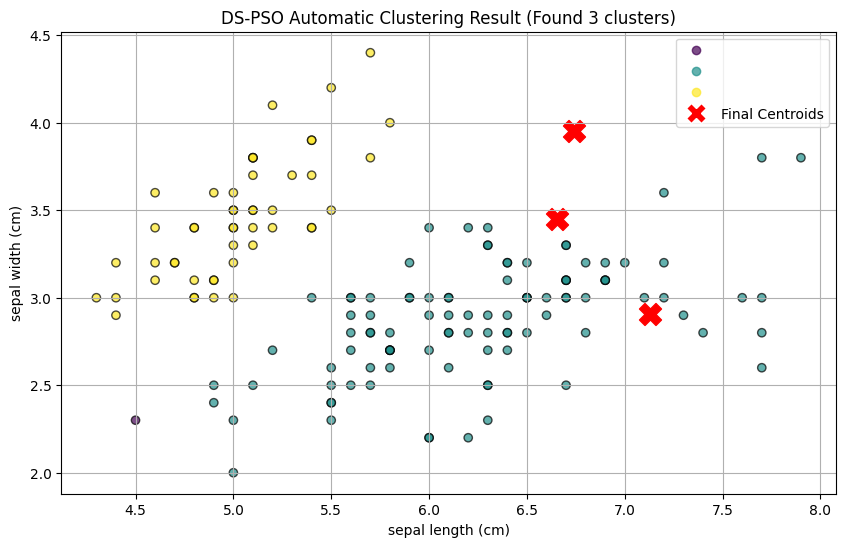

In [12]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', alpha=0.7, edgecolors='k')

# Plot the final active centroids
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], 
          c='red', s=250, marker='X', label='Final Centroids')

plt.title(f'DS-PSO Automatic Clustering Result (Found {final_n_clusters} clusters)')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.legend(handles=scatter.legend_elements()[0] + [plt.Line2D([0], [0], marker='X', color='w', label='Final Centroids', markerfacecolor='red', markersize=15)])
plt.grid(True)
plt.show()